In [1]:
import torch

In [2]:
class RNN:
    def __init__(self,input_size,hidden_size):
        self.w_xh=torch.nn.Linear(input_size,hidden_size)
        self.w_hh=torch.nn.Linear(hidden_size,hidden_size)

    def __call__(self, x,hidden):
        return self.step(x,hidden)
    def step(self,x,hidden):
        h1=self.w_hh(hidden)
        w1=self.w_xh(x)
        out=torch.tanh(h1+w1)
        hidden=self.w_hh.weight
        return out,hidden



In [3]:
rnn=RNN(20,50) #input,hidden
input=torch.randn(32,20)
h_0=torch.randn(32,50)
seq_len = input.shape[0]
seq_len

32

In [4]:
for i in range(seq_len):
    output,hn=rnn(input[i,:],h_0)
output.size(),h_0.size()

(torch.Size([32, 50]), torch.Size([32, 50]))

In [5]:
rnn = torch.nn.RNN(20, 50, 2)
input = torch.randn(100, 32, 20)
h_0 =torch.randn(2, 32 ,50)
output,hn=rnn(input, h_0)
print(output.size(), hn.size())

torch.Size([100, 32, 50]) torch.Size([2, 32, 50])


In [6]:
lstm = torch.nn.LSTM(10, 20,2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, hn = lstm(input, (h0, c0))
print(output.size(), hn[0].size(), hn[1].size())

torch.Size([5, 3, 20]) torch.Size([2, 3, 20]) torch.Size([2, 3, 20])


In [7]:
rnn = torch.nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h_0= torch.randn(2, 3, 20)
output, hn = rnn(input, h0)
print(output.size(),hn.size())

torch.Size([5, 3, 20]) torch.Size([2, 3, 20])


In [16]:
embedding=torch.nn.Embedding(10,3)
input=torch.LongTensor([[1,2,4,5,6],[4,5,2,9,8]])
input

tensor([[1, 2, 4, 5, 6],
        [4, 5, 2, 9, 8]])

In [17]:
output=embedding(input)
output

tensor([[[ 0.2708,  0.7785,  0.0667],
         [ 0.4805, -2.6265,  0.0632],
         [ 0.5160, -0.7523,  0.0703],
         [ 0.8099, -0.2799,  0.1916],
         [ 0.3143, -0.1735,  0.6809]],

        [[ 0.5160, -0.7523,  0.0703],
         [ 0.8099, -0.2799,  0.1916],
         [ 0.4805, -2.6265,  0.0632],
         [-0.5394,  0.3558, -0.7579],
         [-0.1502, -0.5987, -1.7216]]], grad_fn=<EmbeddingBackward0>)

# 通过Sin预测Cos

In [32]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
TIME_STEP=10 #RNN时序步数
INPUT_SIZE=1 #RNN输入维度
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN=64 #
EPOCH=300
h_state=None #隐藏层状态

In [33]:
steps=np.linspace(0,np.pi*2,256,dtype=np.float32)
x_np=np.sin(steps)
y_np=np.cos(steps)

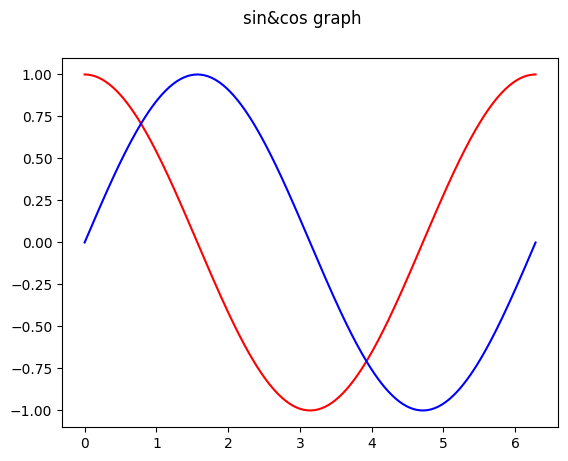

In [34]:
plt.figure(1)
plt.suptitle('sin&cos graph')
plt.plot(steps,y_np,'r-',label='traget(cos)')
plt.plot(steps,x_np,'b-',label='input(sin)')
plt.show()

In [44]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.rnn=nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN,
            num_layers=1,
            batch_first=True,
        )
        self.out=nn.Linear(HIDDEN,1)

    def forward(self,x,h_state):
        r_out,h_state=self.rnn(x,h_state)
        out=[]
        for time_step in range(r_out.size(1)):
            out.append(self.out(r_out[:,time_step,:]))
        return torch.stack(out,dim=1),h_state
RNN()

RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
rnn=RNN().to(DEVICE)
opt=torch.optim.Adam(rnn.parameters())
crit=nn.MSELoss()

EPOCHS: 99,Loss:0.002477


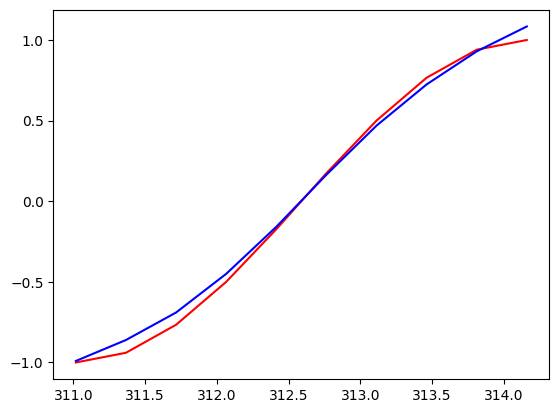

EPOCHS: 199,Loss:0.020704


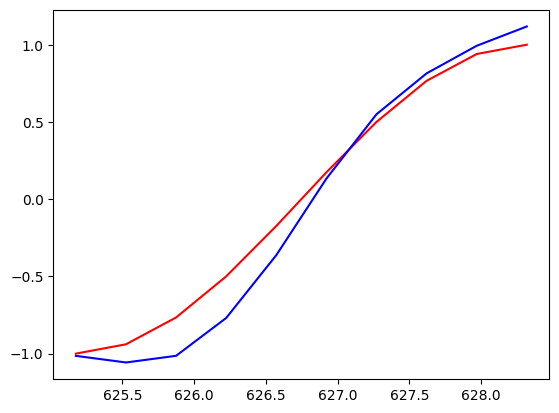

EPOCHS: 299,Loss:0.001566


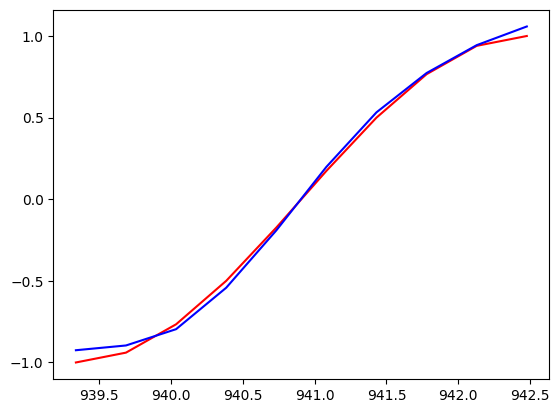

In [42]:
rnn.train()
plt.figure(2)
for step in range(EPOCH):
    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np=np.sin(steps)
    y_np=np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])
    y = torch.from_numpy(y_np[np.newaxis,:,np.newaxis])#增加维度
    x=x.to(DEVICE)
    prediction,h_state=rnn(x,h_state)
    h_state=h_state.data
    loss=crit(prediction.cpu(),y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if (step+1)%100==0: #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.01)


